In [1]:
!pip install astropy==5.3;
!pip install pyregion;
!pip install photutils;
!pip install spectral_cube;
!pip install radio_beam;
!pip install regions;
!pip install casa-formats-io
!pip install aplpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: astropy
    Found existing installation: astropy 5.3.2
    Uninstalling astropy-5.3.2:
      Successfully uninstalled astropy-5.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.1/978.1 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyregion: filename=pyregion-2.2.0-cp310-cp310-linux_x86_64.whl size=424477 sha256=6275a46338d9ac3f0c27ecbb85ba40235a6c4e3682a0bf6a88cb978ecaefdac1
  Stored in directory: /root/.cache/pip/wheels/d9/70/ba/133c9854fc976d08620a301e977d089103a5bf96cc55f68224
Successfully built pyregion
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.5/228.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 6.5 MB/s eta 0:00:00
     

In [2]:
# np.__version__

In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import numpy as np
import scipy
import scipy.integrate as integrate
import aplpy
import warnings
warnings.filterwarnings('ignore')
# from numba import njit, prange

In [4]:
from google.colab import drive
drive.mount('/content/drive')
pathd = '/content/drive/MyDrive/Codes/'

Mounted at /content/drive


Creating a function to calculate the rms

In [5]:
def rms_function(array):
    N = len(array)
    rms = np.sqrt(np.sum(array**2)/N)
    return rms

Creating a function to do the clipping

In [6]:
def clipper(array,rms, pb_mask):
    clipped_array = np.zeros([array.shape[0],array.shape[1],array.shape[2]])
    for k in range(0,array.shape[0],1):
        array[k,:,:] = np.multiply(pb_mask,array[k,:,:])
        for i in range(0,array.shape[1],1):
            for j in range(0,array.shape[2],1):
                if array[k,i,j] >= rms:
                    clipped_array[k,i,j] = array[k,i,j]
                else:
                    clipped_array[k,i,j] = 0
    return clipped_array

Creating a function that returns the moments

In [7]:
def moments(cube,factor, pb_mask):
    cube_data    = cube.data
    header       = cube.header
    cube_data    = np.nan_to_num(cube_data)
    del header['HISTORY']

    v = cube_data.shape[0]
    x = cube_data.shape[1]
    y = cube_data.shape[2]
    V_d        = (1-header['CRVAL3']/header['RESTFRQ'])*2.99999e5                                         #converts central freq to velocity
    V_u        = (1-(header['CRVAL3']+header['CDELT3']*header['NAXIS3'])/header['RESTFRQ'])*2.99999e5     # calculates the lower frequency
    deltaV     = (V_u-V_d)/header['NAXIS3']

    slice_1    = cube_data[4,:,:]
    slice_2    = cube_data[-4,:,:]

    # npixels =

    rms        = 0.5*(rms_function(slice_1)+rms_function(slice_2))    #correct dividing by no of pixels in a beam

    cube_data  = clipper(cube_data,factor*0.008,pb_mask)

    v_axis     = np.linspace(0,v-1,v,dtype=int)
    M0   = np.zeros([x,y])
    M1   = np.zeros([x,y])
    M2   = np.zeros([x,y])
    vl   = np.linspace(V_d,V_u,v)
    for i in range(0,x,1):
        for j in range(0,y,1):
            M0[i,j] = scipy.integrate.simps(cube_data[:,i,j],v_axis)*deltaV
            M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j],v_axis)*deltaV)/M0[i,j]
            M2[i,j] = np.sqrt((scipy.integrate.simps(cube_data[:,i,j]*(vl-M1[i,j])**2,v_axis)*deltaV)/M0[i,j])


    new_header          = header
    new_header['NAXIS'] = 2
    del new_header['NAXIS3']
    del new_header['CTYPE3']
    del new_header['CRVAL3']
    del new_header['CDELT3']
    del new_header['CRPIX3']
    del new_header['CUNIT3']
    del new_header['PC4_1']
    del new_header['PC4_2']
    del new_header['PC1_4']
    del new_header['PC2_4']
    del new_header['PC4_4']

    mom_0 = fits.PrimaryHDU(M0.astype('float'), new_header)
    mom_1 = fits.PrimaryHDU(M1.astype('float'), new_header)
    mom_2 = fits.PrimaryHDU(M2.astype('float'), new_header)
    return mom_0,mom_1,mom_2

Creating a mask around the galaxy in order to get rid of the noisy edges

In [8]:
import pyregion
a = """image \npolygon({},{},{},{},{},{},{},{},{},{},{},{},{},{})""".format(72,379, 72,212,228,8,452 ,8, 452,245, 215,489,121,489 )
region = []
region.append(a)
r = pyregion.parse(region[0])
envelope_mask      = r.get_mask(shape=[500, 500])

Calculating the moments from the fits file

In [9]:
cube         = fits.open('/content/drive/MyDrive/Codes/Galaxyfits/NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
momento_0, momento_1, momento_2 = moments(cube,5,envelope_mask)

Plotting the moments

INFO:astropy:Auto-setting vmin to -6.544e-01
INFO:astropy:Auto-setting vmax to  7.264e+00


INFO: Auto-setting vmin to -6.544e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.264e+00 [aplpy.core]


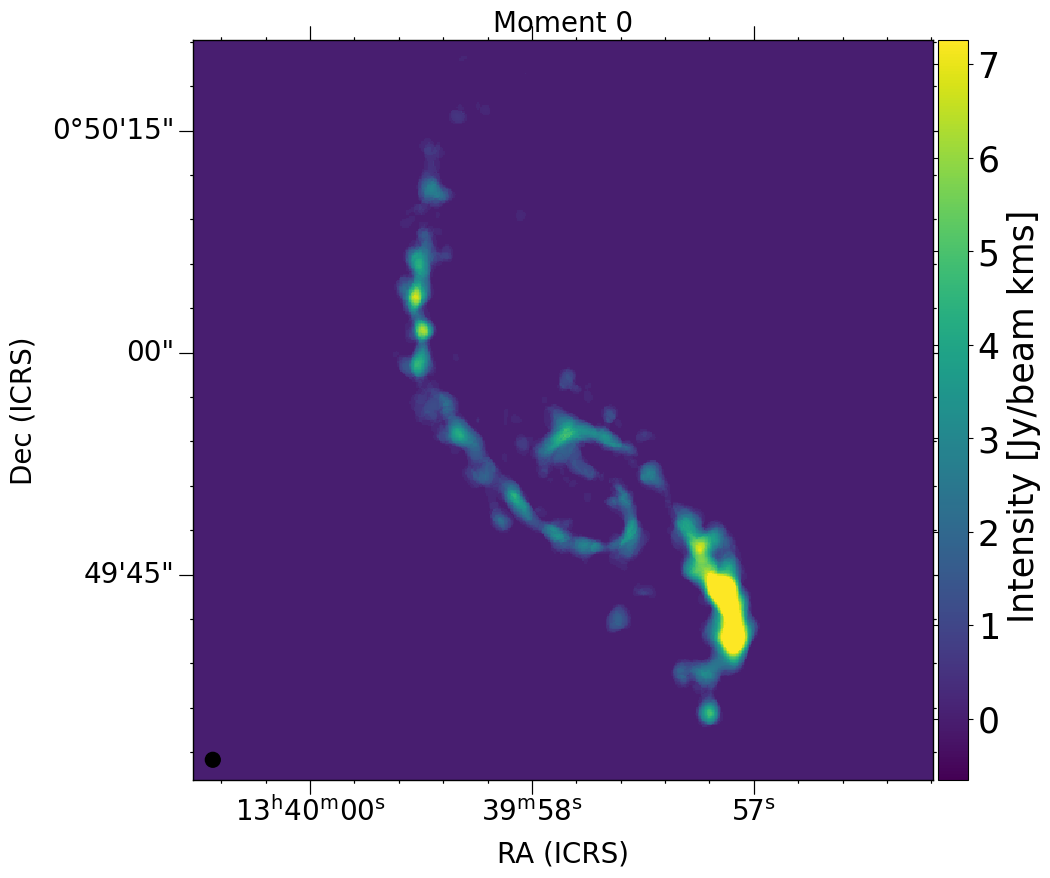

In [10]:
fig = aplpy.FITSFigure(momento_0, figsize=(10, 10))
fig.set_title('Moment 0',fontsize=20)
fig.show_colorscale(cmap='viridis')
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Intensity [Jy/beam kms] ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

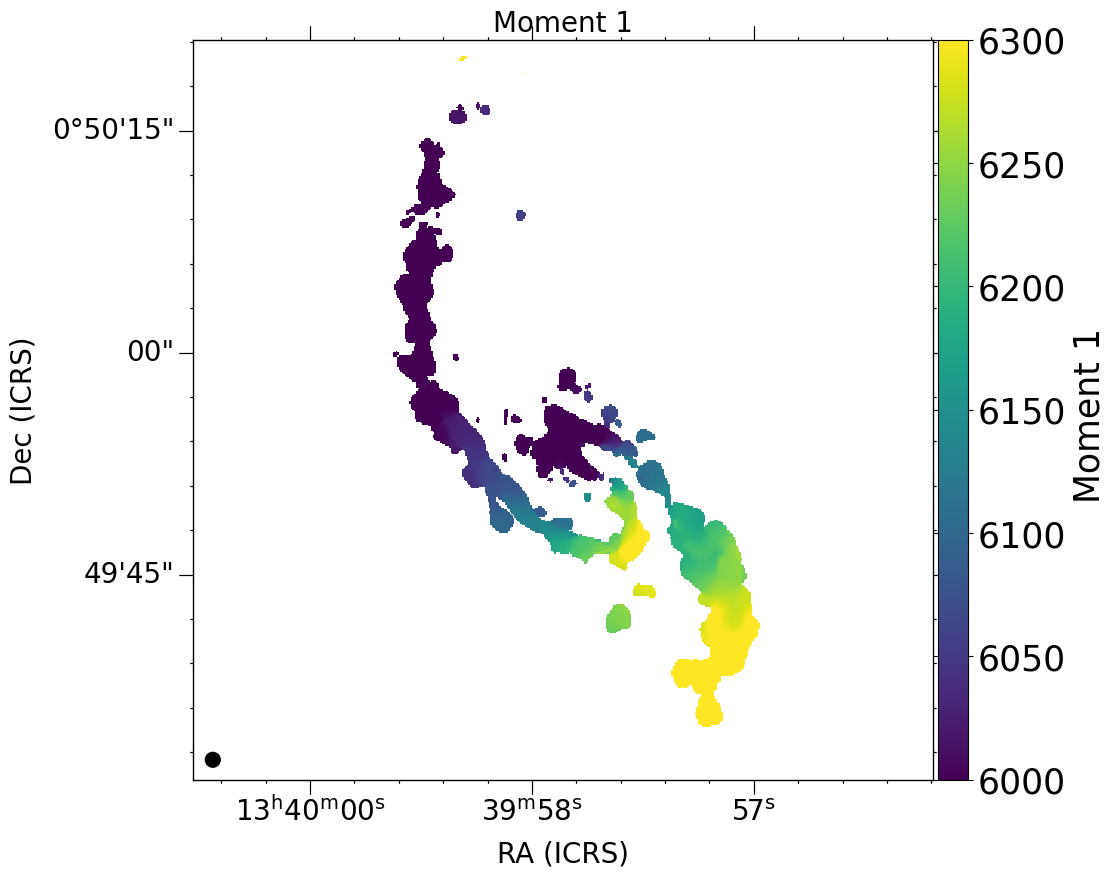

In [11]:
fig = aplpy.FITSFigure(momento_1, figsize=(10, 10))
fig.set_title('Moment 1',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin=6000,vmax = 6300)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 1 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

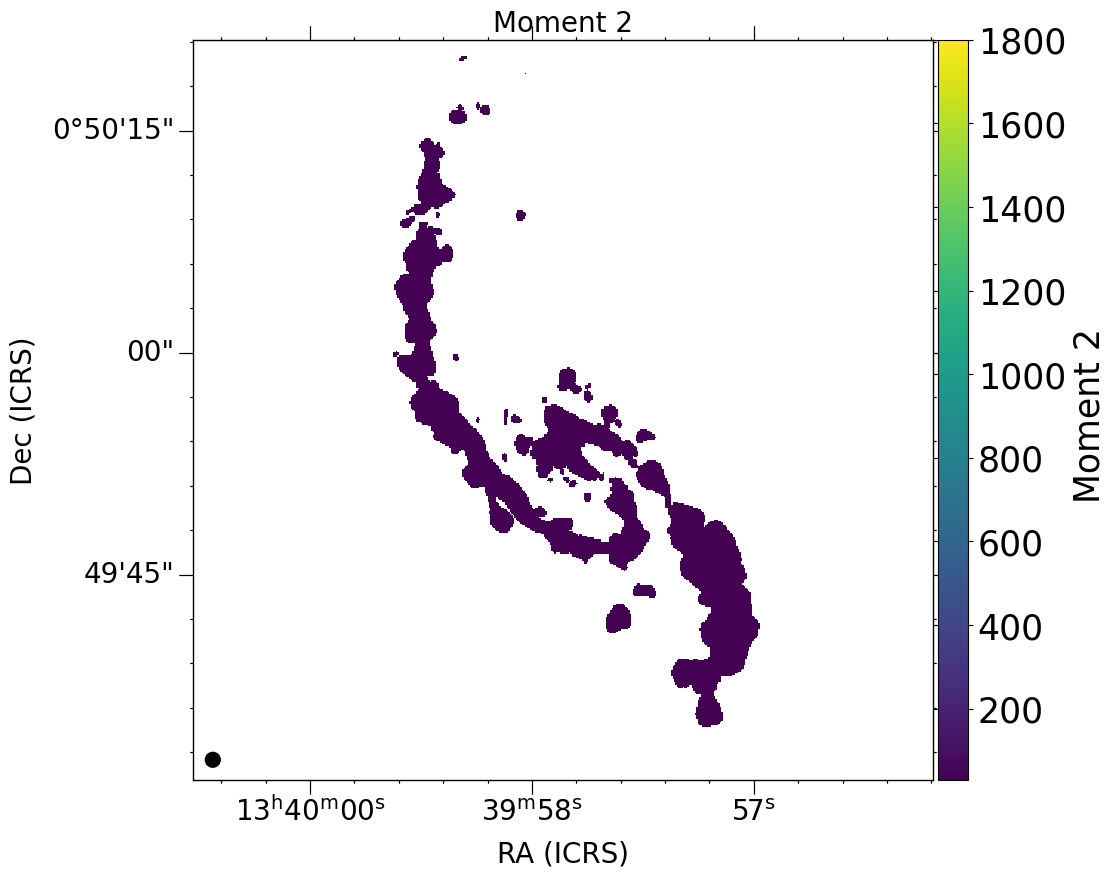

In [12]:
fig = aplpy.FITSFigure(momento_2, figsize=(10, 10))
fig.set_title('Moment 2',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin=30,vmax = 1800)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 2 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

Another way of getting the moment maps is by smoothing the images in order to define better the region, then creating a mask and defining the galaxy shape from that mask

In [13]:
image       = fits.open('NGC5258_s_concat_uvt_dot75asec_rbeam1asec_csdot1.pbcor_hcorr.fits')[0]
image_data  = image.data
image_header= image.header


import scipy as sp
import scipy.ndimage

smoothing_factor = 10

y = sp.ndimage.filters.gaussian_filter(image_data, [smoothing_factor,smoothing_factor], mode='constant')

smoothed_image = fits.PrimaryHDU(y.astype('float'), image_header)
smoothed_image_data = smoothed_image.data

fig = aplpy.FITSFigure(smoothed_image, figsize=(12, 12))
fig.show_colorscale(cmap='viridis')

rms = 1.6e-5

x = image_data.shape[0]
y = image_data.shape[1]

mask = np.zeros([x,y],type(bool))

for i in range (0,x,1):
    for j in range (0,y,1):
        if smoothed_image_data[i,j] >= rms:
            mask [i,j] = True
        else:
            mask [i,j] = False

FileNotFoundError: ignored

In [ ]:
mask_hdu = fits.PrimaryHDU(mask.astype('float'), image_header)
fig = aplpy.FITSFigure(mask_hdu, figsize=(12, 12))
fig.show_colorscale(cmap='viridis')

In [ ]:
cube         = fits.open('NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
momento_0, momento_1, momento_2 = moments(cube,5,mask)

In [ ]:
fig = aplpy.FITSFigure(momento_0, figsize=(12, 12))
fig.show_colorscale(cmap='viridis')
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Intensity [Jy/beam kms] ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

In [ ]:
fig = aplpy.FITSFigure(momento_1, figsize=(12, 12))
fig.show_colorscale(cmap='viridis',vmin=5900,vmax = 6300)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Momemnt 1 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

In [ ]:
fig = aplpy.FITSFigure(momento_2, figsize=(12, 12))
fig.show_colorscale(cmap='viridis',vmin=30,vmax = 3000)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 2 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

In [ ]:
wcs_galaxy